Interested in the area of the region south of the SUC of $\psi_g$ in OM4 and the variability of this value, particularly in the Ross Gyre region. The hypothesis is that this might be related to MLD/buoyancy/convection.

I'll just start with the annual timeseries.

In [1]:
import xarray as xr
import dask.array
import numpy as np
import pandas as pd
import os
import scipy.io
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import sys
sys.path.append('/home/Ruth.Moorman/Southern_ACC_boundary_dynamics')
### import required python functions
from om4_tools import *
# from ssh_contours import *
## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import cmocean.cm as cm
from matplotlib import rc, rcParams
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
sys.path.append('/home/Ruth.Moorman/')
from datetime import datetime
import nclcmaps
import cv2

In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import subprocess as sp
uid = int( sp.check_output('id -u', shell=True).decode('utf-8').replace('\n','') )
portdash = 10000 + uid
cluster = SLURMCluster(queue='analysis', cores=4, project='gfdl_o',memory="24GB", walltime="00:30:00",dashboard_address=f':{portdash}')
cluster.scale(2)
client = Client(cluster)
print(client)
print('http://localhost:'+str(portdash)+'/status')

<Client: 'tcp://140.208.147.176:38363' processes=0 threads=0, memory=0 B>
http://localhost:30552/status


In [3]:
rcParams["contour.negative_linestyle"] = 'solid'
rc('xtick', labelsize=20) 
rc('ytick', labelsize=20) 
rc('axes', labelsize=20)

In [4]:
def so_basics(ax,land_mask,geolon, geolat, lat_north = -29, grid = True):
    latslice = slice(-90,lat_north)
    ax.contour(geolon.sel(yh = latslice), geolat.sel(yh = latslice),land_mask.sel(yh = latslice),[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--', alpha = 0.7)
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50, -40, -30])

In [5]:
#static
expdir = '/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/'
static_25 = xr.open_dataset(expdir+'/cycle1/ocean_static/20170101.ocean_static.nc')
bathy_25 = static_25.deptho.sel(yh = slice(-90,-29)).load()
land_mask_25 = static_25.wet_u.sel(yh = slice(-90,-29)).load()
#
static_5 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r_cycle1/gfdl.ncrc4-intel16f2-prod/pp/ocean_monthly/ocean_monthly.static.nc')
bathy_5 = static_5.deptho.sel(yh = slice(-90,-29)).load()
land_mask_5 = static_5.wet_u.sel(yh = slice(-90,-29)).load()
#
exp_dir = '/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle2/gfdl.ncrc4-intel16f2-prod/pp'
static_125 = xr.open_dataset(exp_dir+'/ocean_daily/ocean_daily.static.nc')
bathy_125 = static_125.deptho.sel(yh = slice(-90,-29)).load()
land_mask_125 = static_125.wet_u.sel(yh = slice(-90,-29)).load()

In [3]:
p5_annual_SUCpsig = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/annual_SUC_psig.nc', chunks = {'time':1})
p125_annual_SUCpsig = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/annual_SUC_psig.nc', chunks = {'time':1})
p25_annual_SUCpsig = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/annual_SUC_psig-attempt-1.nc', chunks = {'time':1})
p125_mle_annual_SUCpsig = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/annual_SUC_psig.nc', chunks = {'time':1})

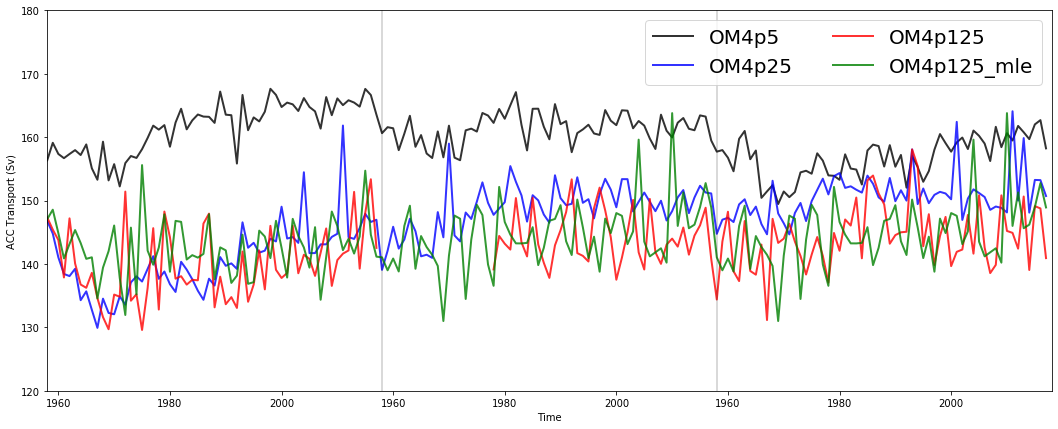

In [4]:
# first, a timeseries of the ACC barotropic streamfunction transport
plt.figure(figsize = (18,7))
ax = plt.subplot()
ax.plot(p5_annual_SUCpsig.time, p5_annual_SUCpsig.SUC_psig, 'k', linewidth = 2, alpha = 0.8,label = 'OM4p5')
# ax.plot(p25_annual_SUCpsig_old.time, p25_annual_SUCpsig_old.SUC_psig, 'b', linewidth = 2, alpha = 0.8,label = 'OM4p25')
ax.plot(p25_annual_SUCpsig.time, p25_annual_SUCpsig.SUC_psig, 'b', linewidth = 2, alpha = 0.8,label = 'OM4p25')
ax.plot(p125_annual_SUCpsig.time, p125_annual_SUCpsig.SUC_psig, 'r', linewidth =2, alpha = 0.8,label = 'OM4p125')
ax.plot(p125_mle_annual_SUCpsig.time, p125_mle_annual_SUCpsig.SUC_psig, 'g', linewidth = 2, alpha = 0.8,label = 'OM4p125_mle')
ax.set_xlim([np.datetime64('1838'),np.datetime64('2018')])
ax.set_ylim([120,180])
ax.plot(np.array(['1898','1898'],dtype = np.datetime64), [120,180], 'k', alpha = 0.2)
ax.plot(np.array(['1958','1958'],dtype = np.datetime64), [120,180], 'k', alpha = 0.2)
xticks = np.array(['1840','1860','1880','1900','1920','1940','1960','1980','2000'], dtype = np.datetime64)
ax.set_xticks(xticks)
xticks = np.array([1960,1980,2000,1960,1980,2000,1960,1980,2000])
ax.set_xticklabels(xticks)
ax.set_ylabel('ACC Transport (Sv)')
ax.set_xlabel('Time')
ax.legend(loc = 1, fontsize = 20, ncol = 2)
plt.show()

In [5]:
p5_annual_SUCpsig_mask = p5_annual_SUCpsig.SUC_psig_mask
p25_annual_SUCpsig_mask = p25_annual_SUCpsig.SUC_psig_mask
p125_annual_SUCpsig_mask = p125_annual_SUCpsig.SUC_psig_mask
p125_mle_annual_SUCpsig_mask = p125_mle_annual_SUCpsig.SUC_psig_mask

In [43]:
# how different does this look if we cut out the continental shelf region
p5_shelf_mask = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/isobaths/OM4p5_Antarctic_1000m_isobath_u.nc')
p25_shelf_mask = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/isobaths/OM4p25_Antarctic_1000m_isobath_u.nc')
p125_shelf_mask = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/isobaths/OM4p125_Antarctic_1000m_isobath_u.nc')

In [44]:
p5_shelf_mask_south = p5_shelf_mask.contour_masked_south
p25_shelf_mask_south = p25_shelf_mask.contour_masked_south
p125_shelf_mask_south = p125_shelf_mask.contour_masked_south

In [45]:
## we actually want to mask for north
p5_shelf_mask_north = (p5_shelf_mask_south*0).fillna(1)
p5_shelf_mask_north = p5_shelf_mask_north.where(p5_shelf_mask_north>0)
p25_shelf_mask_north = (p25_shelf_mask_south*0).fillna(1)
p25_shelf_mask_north = p25_shelf_mask_north.where(p25_shelf_mask_north>0)
p125_shelf_mask_north = (p125_shelf_mask_south*0).fillna(1)
p125_shelf_mask_north = p125_shelf_mask_north.where(p125_shelf_mask_north>0)

In [46]:
p5_annual_gyre_mask = p5_annual_SUCpsig_mask * p5_shelf_mask_north
p25_annual_gyre_mask = p25_annual_SUCpsig_mask * p25_shelf_mask_north
p125_annual_gyre_mask = p125_annual_SUCpsig_mask * p125_shelf_mask_north
p125_mle_annual_gyre_mask = p125_mle_annual_SUCpsig_mask * p125_shelf_mask_north

In [63]:
p5_annual_gyre_density = p5_annual_gyre_mask.fillna(0).sum(dim = 'time')
p25_annual_gyre_density = p25_annual_gyre_mask.fillna(0).sum(dim = 'time')
p125_annual_gyre_density = p125_annual_gyre_mask.fillna(0).sum(dim = 'time')
p125_mle_annual_gyre_density = p125_mle_annual_gyre_mask.fillna(0).sum(dim = 'time')

In [64]:
p5_annual_gyre_density = p5_annual_gyre_density.where(p5_annual_gyre_density>0).load()
p25_annual_gyre_density = p25_annual_gyre_density.where(p25_annual_gyre_density>0).load()
p125_annual_gyre_density = p125_annual_gyre_density.where(p125_annual_gyre_density>0).load()
p125_mle_annual_gyre_density = p125_mle_annual_gyre_density.where(p125_mle_annual_gyre_density>0).load()


In [65]:
p5_annual_gyre_density_norm = p5_annual_gyre_density/p5_annual_gyre_density.max().values * 100
p25_annual_gyre_density_norm = p25_annual_gyre_density/p25_annual_gyre_density.max().values * 100
p125_annual_gyre_density_norm = p125_annual_gyre_density/p125_annual_gyre_density.max().values * 100
p125_mle_annual_gyre_density_norm = p125_mle_annual_gyre_density/p125_mle_annual_gyre_density.max().values * 100

In [66]:
p5_annual_gyre_density_norm =p5_annual_gyre_density_norm.load()
p25_annual_gyre_density_norm =p25_annual_gyre_density_norm.load()
p125_annual_gyre_density_norm =p125_annual_gyre_density_norm.load()
p125_mle_annual_gyre_density_norm =p125_mle_annual_gyre_density_norm.load()

In [51]:
# obs
CMEMS_ssh_satellite = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/CMEMS-satellite-obs/CMEMS_1993-2017_mean_SUC-ssh.nc')
CMEMS_ssh_satellite_mask = CMEMS_ssh_satellite.contour_masked_south
CMEMS_ssh_satellite_numbers = CMEMS_ssh_satellite.contour_mask_numbered

In [156]:
geolon =static_5.geolon.sel(yh = slice(-90,-29))
geolat =static_5.geolat.sel(yh = slice(-90,-29))

RG_mask5 = (geolon.where(geolon<-65).where(geolon>-220)*0+1).where(geolat<-55).where(geolat>-78)
WG_mask5 = (geolon.where(geolon>-65).where(geolon<59.7)*0+1).where(geolat<-45).where(geolat>-78)
KG_mask5 = (geolon.where(geolon<-220)*0+1).where(geolat<-50).where(geolat>-78)

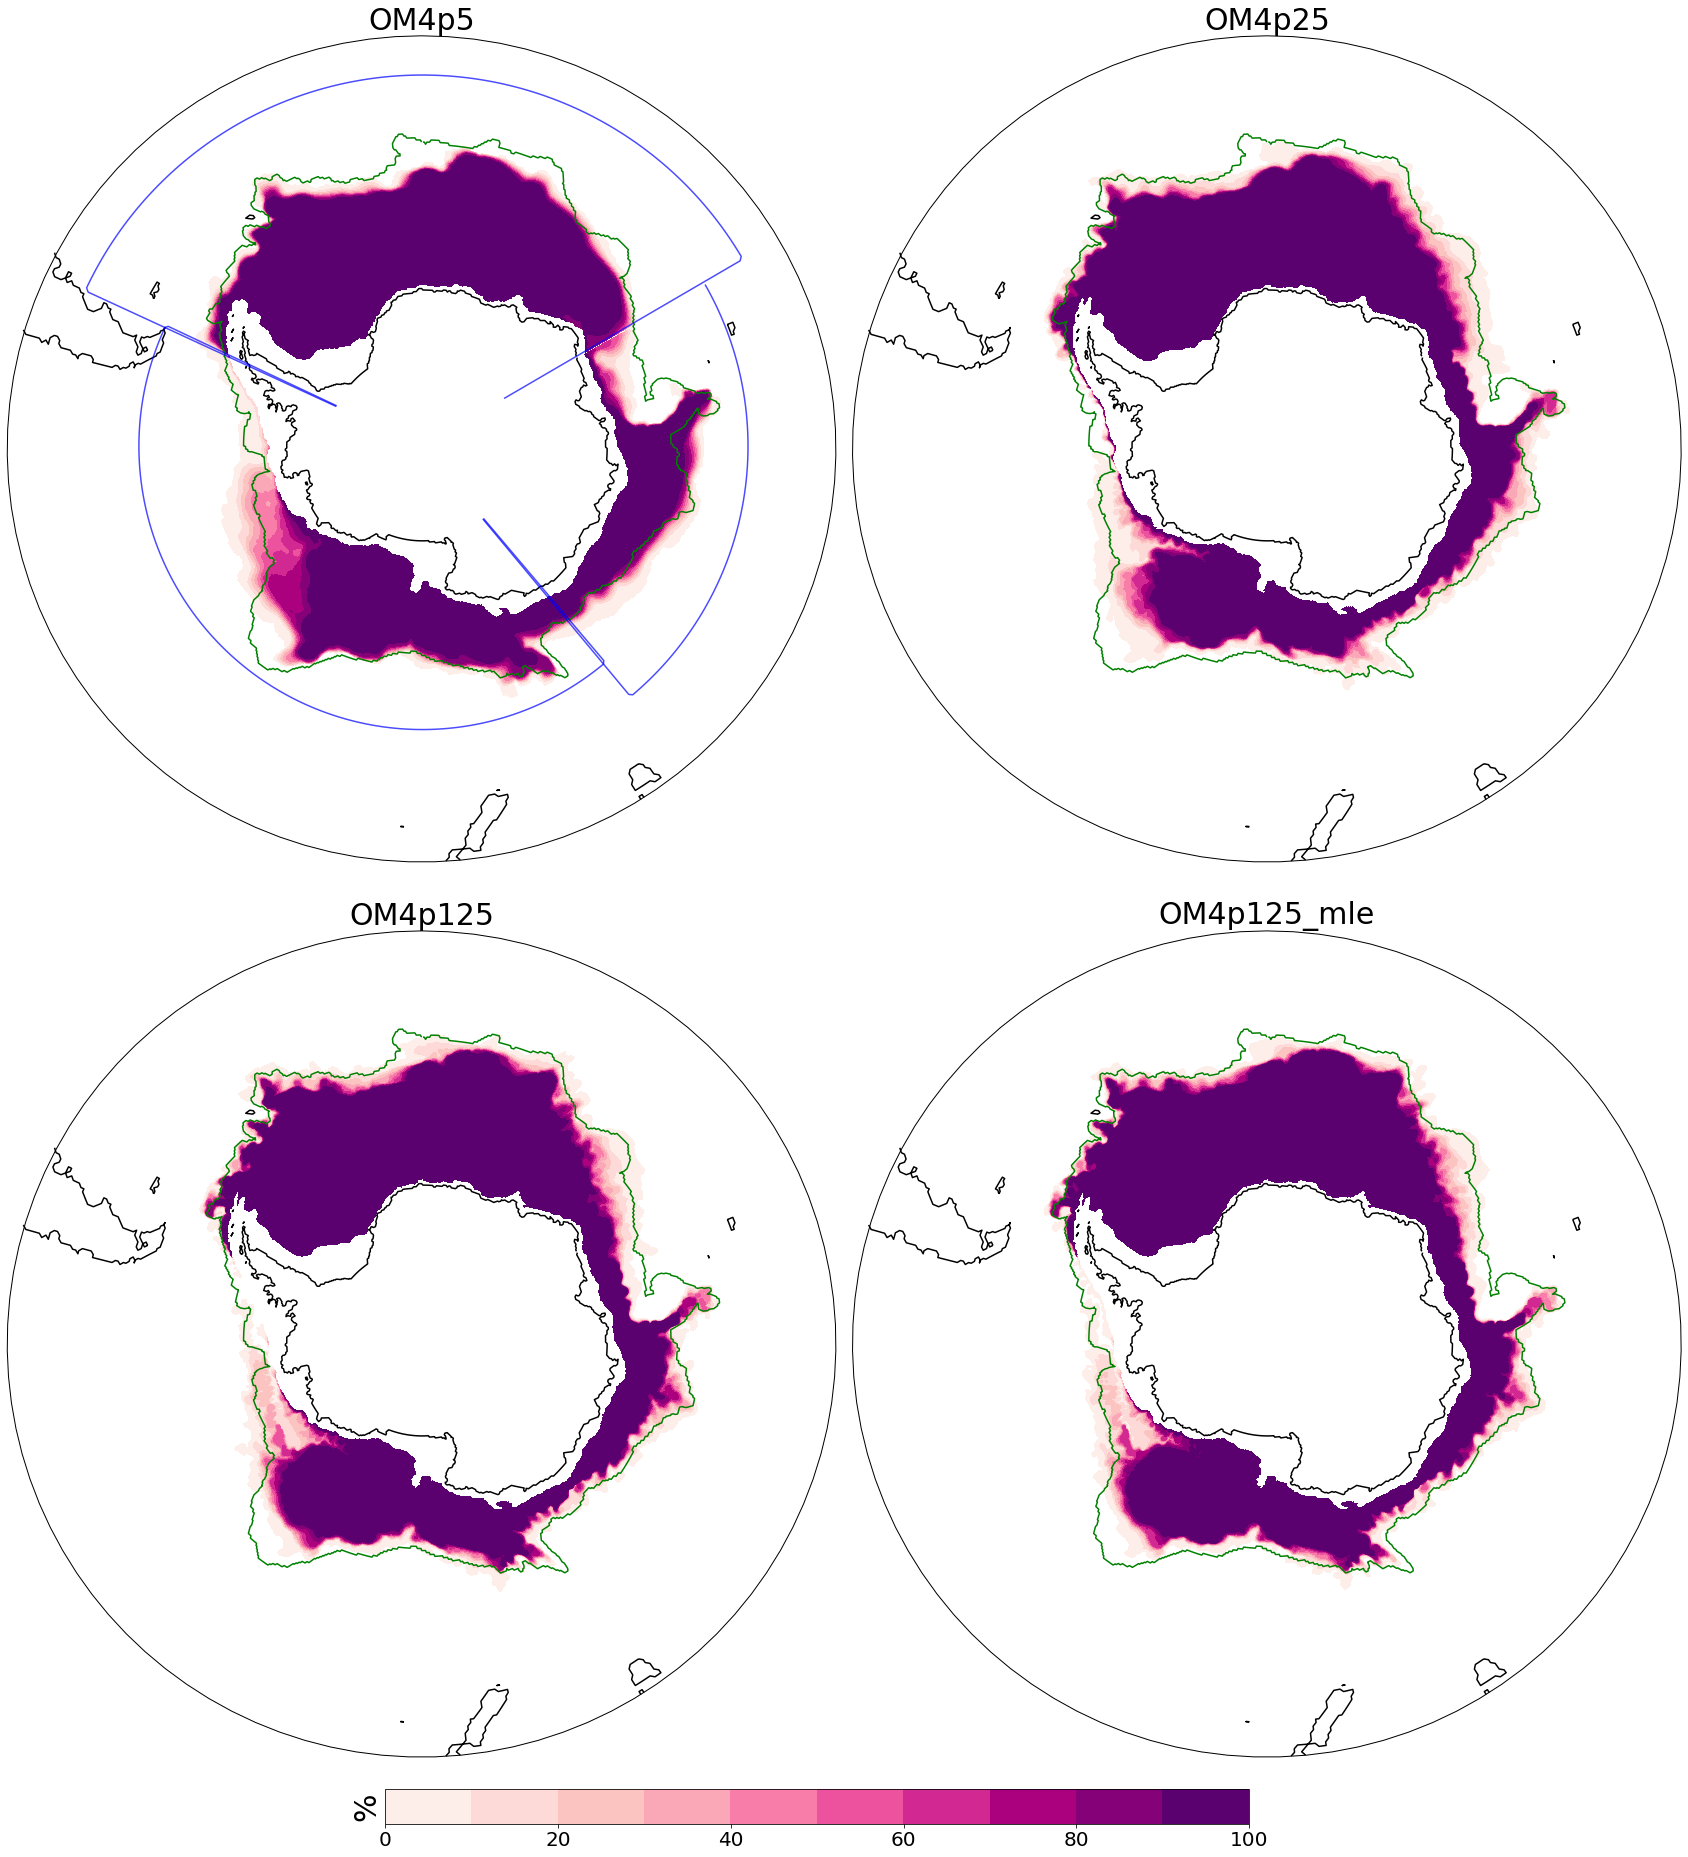

In [157]:
fig = plt.figure(figsize=[30, 32])
gs = gridspec.GridSpec(2,2)
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax,ax1,ax2,ax3 = plt.subplot(gs[0],projection = proj),plt.subplot(gs[1],projection = proj), plt.subplot(gs[2],projection = proj), plt.subplot(gs[3],projection = proj)
gs.update(wspace = 0.02, hspace = 0.06)

land_mask =land_mask_5
geolon =static_5.geolon.sel(yh = slice(-90,-29))
geolat =static_5.geolat.sel(yh = slice(-90,-29))

lat_north = -40
so_basics(ax,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax1,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax2,land_mask,geolon, geolat, lat_north = lat_north, grid = False)
so_basics(ax3,land_mask,geolon, geolat, lat_north = lat_north, grid = False)

lvls = np.arange(0,110,10)
cmap = nclcmaps.cmap('MPL_RdPu')
c = ax.contourf(p5_annual_gyre_density_norm.geolon, p5_annual_gyre_density_norm.geolat,p5_annual_gyre_density_norm,levels = lvls, cmap = cmap,transform = ccrs.PlateCarree())
ax1.contourf(p25_annual_gyre_density_norm.geolon, p25_annual_gyre_density_norm.geolat,p25_annual_gyre_density_norm,levels = lvls, cmap = cmap,transform = ccrs.PlateCarree())
ax2.contourf(p125_annual_gyre_density_norm.geolon, p125_annual_gyre_density_norm.geolat,p125_annual_gyre_density_norm,levels = lvls, cmap = cmap,transform = ccrs.PlateCarree())
ax3.contourf(p125_mle_annual_gyre_density_norm.geolon, p125_mle_annual_gyre_density_norm.geolat,p125_mle_annual_gyre_density_norm,levels = lvls, cmap = cmap,transform = ccrs.PlateCarree())

ax.contour(CMEMS_ssh_satellite_mask.longitude, CMEMS_ssh_satellite_mask.latitude,CMEMS_ssh_satellite_mask.fillna(0), levels = [0,1], colors = 'g', alpha = 1, transform = ccrs.PlateCarree())
ax1.contour(CMEMS_ssh_satellite_mask.longitude, CMEMS_ssh_satellite_mask.latitude,CMEMS_ssh_satellite_mask.fillna(0), levels = [0,1], colors = 'g', alpha = 1, transform = ccrs.PlateCarree())
ax2.contour(CMEMS_ssh_satellite_mask.longitude, CMEMS_ssh_satellite_mask.latitude,CMEMS_ssh_satellite_mask.fillna(0), levels = [0,1], colors = 'g', alpha = 1, transform = ccrs.PlateCarree())
ax3.contour(CMEMS_ssh_satellite_mask.longitude, CMEMS_ssh_satellite_mask.latitude,CMEMS_ssh_satellite_mask.fillna(0), levels = [0,1], colors = 'g', alpha = 1, transform = ccrs.PlateCarree())

ax.contour(geolon,geolat,RG_mask5.fillna(0), levels = [0,1], colors = 'b', alpha = 0.7, transform = ccrs.PlateCarree())
ax.contour(geolon,geolat,WG_mask5.fillna(0), levels = [0,1], colors = 'b', alpha = 0.7, transform = ccrs.PlateCarree())
ax.contour(geolon,geolat,KG_mask5.fillna(0), levels = [0,1], colors = 'b', alpha = 0.7, transform = ccrs.PlateCarree())


ax.set_title('OM4p5', fontsize = 30)
ax1.set_title('OM4p25', fontsize = 30)
ax2.set_title('OM4p125', fontsize = 30)
ax3.set_title('OM4p125_mle', fontsize = 30)

cax = fig.add_axes([0.3, 0.1, 0.4, 0.015])
cbar=plt.colorbar(c,cax = cax,orientation='horizontal',shrink = 0.5)
cax.set_ylabel('%', fontsize = 30)

plt.show()

In [70]:
# now, let's look at the area south of the SUC psig as a function of time
# no issues with output coarsening here just use standard cellarea
area_cell_25 = static_25.areacello_cu.sel(yh = slice(-90,-29))
area_cell_5 = static_5.areacello_cu.sel(yh = slice(-90,-29))
area_cell_125 = static_125.areacello_cu.sel(yh = slice(-90,-29))

In [71]:
# do a version excludung (gyre) and including (sso) the shelf
p5_annual_gyre_area = (p5_annual_gyre_mask*area_cell_5).sum(dim = {'yh', 'xq'}).load()
p25_annual_gyre_area = (p25_annual_gyre_mask*area_cell_25).sum(dim = {'yh', 'xq'}).load()
p125_annual_gyre_area = (p125_annual_gyre_mask*area_cell_125).sum(dim = {'yh', 'xq'}).load()
p125_mle_annual_gyre_area = (p125_mle_annual_gyre_mask*area_cell_125).sum(dim = {'yh', 'xq'}).load()


In [72]:
p5_annual_gyre_area = p5_annual_gyre_area.where(p5_annual_gyre_area>0)
p25_annual_gyre_area = p25_annual_gyre_area.where(p25_annual_gyre_area>0)
p125_annual_gyre_area = p125_annual_gyre_area.where(p125_annual_gyre_area>0)
p125_mle_annual_gyre_area = p125_mle_annual_gyre_area.where(p125_mle_annual_gyre_area>0)

In [76]:
p25_annual_gyre_area = p25_annual_gyre_area.where(p25_annual_gyre_area>1e13)

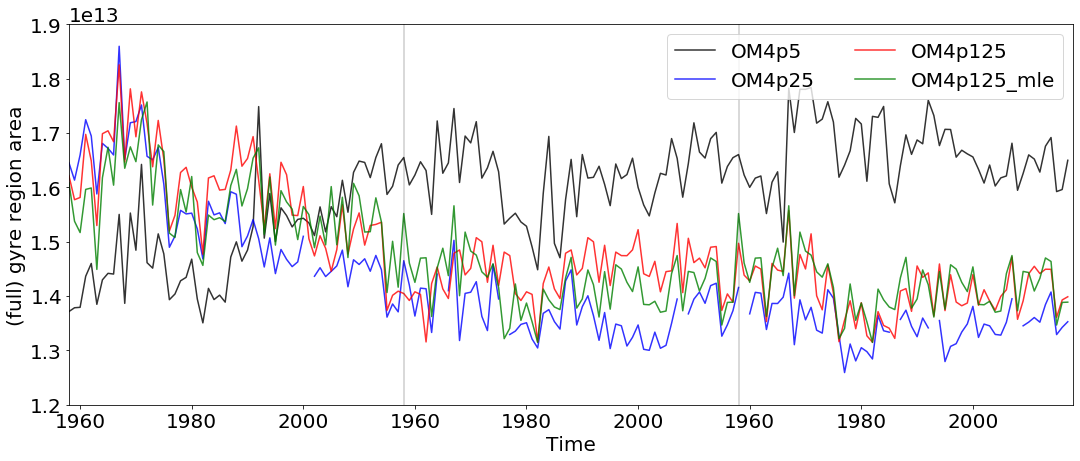

In [81]:
# first, a timeseries of the ACC barotropic streamfunction transport
plt.figure(figsize = (18,7))
ax = plt.subplot()

ax.plot(p5_annual_gyre_area.time, p5_annual_gyre_area, 'k', alpha = 0.8,label = 'OM4p5')
ax.plot(p25_annual_gyre_area.time, p25_annual_gyre_area, 'b' , alpha = 0.8,label = 'OM4p25')
ax.plot(p125_annual_gyre_area.time, p125_annual_gyre_area, 'r', alpha = 0.8,label = 'OM4p125')
ax.plot(p125_mle_annual_gyre_area.time, p125_mle_annual_gyre_area, 'g', alpha = 0.8,label = 'OM4p125_mle')
ax.set_xlim([np.datetime64('1838'),np.datetime64('2018')])
ax.set_ylim([1.2e13,1.9e13])

ax.plot(np.array(['1898','1898'],dtype = np.datetime64), [1.2e13,1.9e13], 'k', alpha = 0.2)
ax.plot(np.array(['1958','1958'],dtype = np.datetime64), [1.2e13,1.9e13], 'k', alpha = 0.2)
xticks = np.array(['1840','1860','1880','1900','1920','1940','1960','1980','2000'], dtype = np.datetime64)
ax.set_xticks(xticks)
xticks = np.array([1960,1980,2000,1960,1980,2000,1960,1980,2000])
ax.set_xticklabels(xticks)
ax.set_ylabel('(full) gyre region area')
ax.set_xlabel('Time')
ax.legend(loc = 1, fontsize = 20, ncol = 2)
plt.show()

In [85]:
p5_annual_gyre_area_rolling = p5_annual_gyre_area.rolling(time=10).mean()
p25_annual_gyre_area_rolling = p25_annual_gyre_area.rolling(time=10).mean()
p125_annual_gyre_area_rolling = p125_annual_gyre_area.rolling(time=10).mean()
p125_mle_annual_gyre_area_rolling = p125_mle_annual_gyre_area.rolling(time=10).mean()


In [97]:
p5_annual_ACC = p5_annual_SUCpsig.SUC_psig.load()
p25_annual_ACC = p25_annual_SUCpsig.SUC_psig.load()
p125_annual_ACC = p125_annual_SUCpsig.SUC_psig.load()
p125_mle_annual_ACC = p125_mle_annual_SUCpsig.SUC_psig.load()


In [98]:
p5_annual_ACC_rolling = p5_annual_ACC.rolling(time = 10).mean()
p25_annual_ACC_rolling = p25_annual_ACC.rolling(time = 10).mean()
p125_annual_ACC_rolling = p125_annual_ACC.rolling(time = 10).mean()
p125_mle_annual_ACC_rolling = p125_mle_annual_ACC.rolling(time = 10).mean()

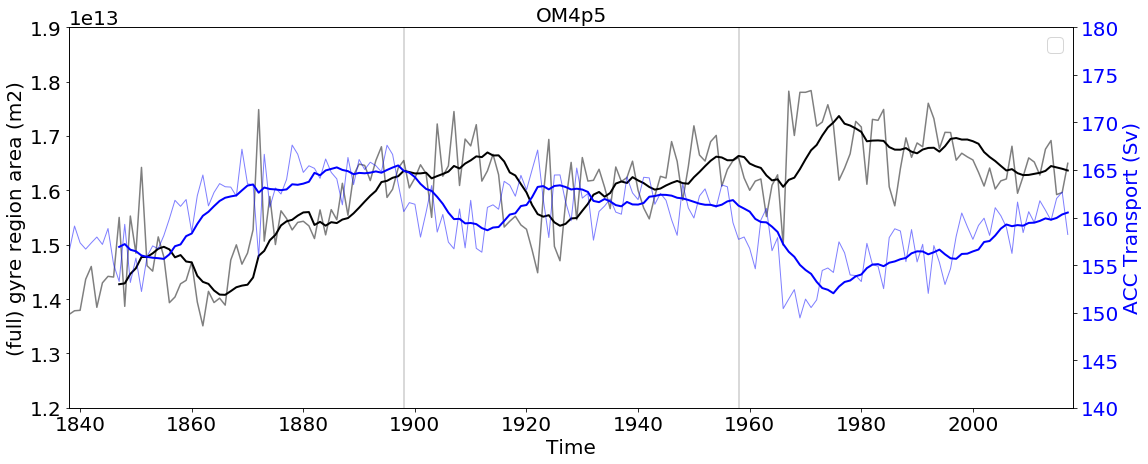

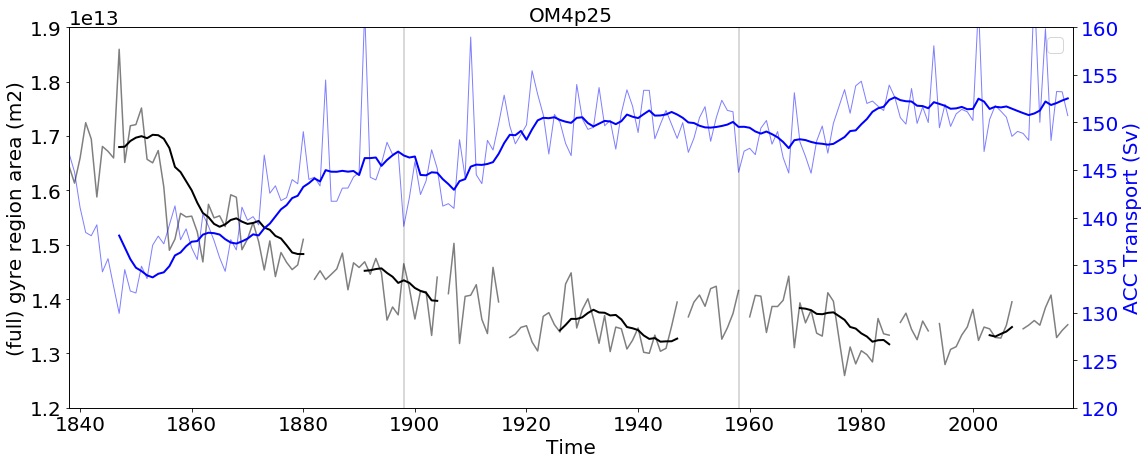

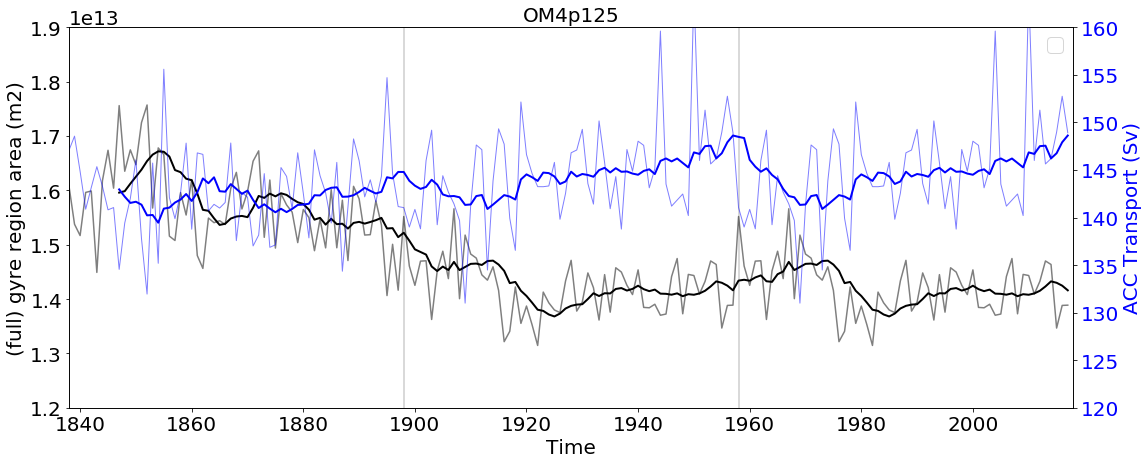

In [110]:
plt.figure(figsize = (18,7))
ax = plt.subplot()

ax.plot(p5_annual_gyre_area.time, p5_annual_gyre_area, 'k', alpha = 0.5)
ax.plot(p5_annual_gyre_area_rolling.time, p5_annual_gyre_area_rolling, 'k', linewidth = 2)
ax.set_ylim([1.2e13,1.9e13])
ax.set_xlim([np.datetime64('1838'),np.datetime64('2018')])

ax.plot(np.array(['1898','1898'],dtype = np.datetime64), [1.2e13,1.9e13], 'k', alpha = 0.2)
ax.plot(np.array(['1958','1958'],dtype = np.datetime64), [1.2e13,1.9e13], 'k', alpha = 0.2)
xticks = np.array(['1840','1860','1880','1900','1920','1940','1960','1980','2000'], dtype = np.datetime64)
ax.set_xticks(xticks)
xticks = np.array([1960,1980,2000,1960,1980,2000,1960,1980,2000])
ax.set_xticklabels(xticks)
ax.set_ylabel('(full) gyre region area (m2)')
ax.set_xlabel('Time')
ax.legend(loc = 1, fontsize = 20, ncol = 2)

ax1 = ax.twinx()  
ax1.plot(p5_annual_ACC.time, p5_annual_ACC, 'b', linewidth = 1, alpha = 0.5)
ax1.plot(p5_annual_ACC_rolling.time, p5_annual_ACC_rolling, 'b', linewidth = 2)
ax1.set_ylim([140,180])
ax1.set_ylabel('ACC Transport (Sv)', color = 'b')
ax1.tick_params(axis='y', labelcolor='b')
ax.set_title('OM4p5', fontsize = 20)
plt.show()

#
plt.figure(figsize = (18,7))
ax = plt.subplot()

ax.plot(p25_annual_gyre_area.time, p25_annual_gyre_area, 'k', alpha = 0.5)
ax.plot(p25_annual_gyre_area_rolling.time, p25_annual_gyre_area_rolling, 'k', linewidth = 2)
ax.set_ylim([1.2e13,1.9e13])
ax.set_xlim([np.datetime64('1838'),np.datetime64('2018')])

ax.plot(np.array(['1898','1898'],dtype = np.datetime64), [1.2e13,1.9e13], 'k', alpha = 0.2)
ax.plot(np.array(['1958','1958'],dtype = np.datetime64), [1.2e13,1.9e13], 'k', alpha = 0.2)
xticks = np.array(['1840','1860','1880','1900','1920','1940','1960','1980','2000'], dtype = np.datetime64)
ax.set_xticks(xticks)
xticks = np.array([1960,1980,2000,1960,1980,2000,1960,1980,2000])
ax.set_xticklabels(xticks)
ax.set_ylabel('(full) gyre region area (m2)')
ax.set_xlabel('Time')
ax.legend(loc = 1, fontsize = 20, ncol = 2)

ax1 = ax.twinx()  
ax1.plot(p25_annual_ACC.time, p25_annual_ACC, 'b', linewidth = 1, alpha = 0.5)
ax1.plot(p25_annual_ACC_rolling.time, p25_annual_ACC_rolling, 'b', linewidth = 2)
ax1.set_ylim([120,160])
ax1.set_ylabel('ACC Transport (Sv)', color = 'b')
ax1.tick_params(axis='y', labelcolor='b')
ax.set_title('OM4p25', fontsize = 20)
plt.show()

#
plt.figure(figsize = (18,7))
ax = plt.subplot()

ax.plot(p125_mle_annual_gyre_area.time, p125_mle_annual_gyre_area, 'k', alpha = 0.5)
ax.plot(p125_mle_annual_gyre_area_rolling.time, p125_mle_annual_gyre_area_rolling, 'k', linewidth = 2)
ax.set_ylim([1.2e13,1.9e13])
ax.set_xlim([np.datetime64('1838'),np.datetime64('2018')])

ax.plot(np.array(['1898','1898'],dtype = np.datetime64), [1.2e13,1.9e13], 'k', alpha = 0.2)
ax.plot(np.array(['1958','1958'],dtype = np.datetime64), [1.2e13,1.9e13], 'k', alpha = 0.2)
xticks = np.array(['1840','1860','1880','1900','1920','1940','1960','1980','2000'], dtype = np.datetime64)
ax.set_xticks(xticks)
xticks = np.array([1960,1980,2000,1960,1980,2000,1960,1980,2000])
ax.set_xticklabels(xticks)
ax.set_ylabel('(full) gyre region area (m2)')
ax.set_xlabel('Time')
ax.legend(loc = 1, fontsize = 20, ncol = 2)

ax1 = ax.twinx()  
ax1.plot(p125_mle_annual_ACC.time, p125_mle_annual_ACC, 'b', linewidth = 1, alpha = 0.5)
ax1.plot(p125_mle_annual_ACC_rolling.time, p125_mle_annual_ACC_rolling, 'b', linewidth = 2)
ax1.set_ylim([120,160])
ax1.set_ylabel('ACC Transport (Sv)', color = 'b')
ax1.tick_params(axis='y', labelcolor='b')
ax.set_title('OM4p125', fontsize = 20)
plt.show()

In [ ]:
RG_mask5 = (geolon.where(geolon<-65).where(geolon>-220)*0+1).where(geolat<-55).where(geolat>-78)
KG_mask5 = (geolon.where(geolon<-220)*0+1).where(geolat<-50).where(geolat>-78)

In [158]:
## Ross/Weddell/Kerguellen Gyre area
p5_annual_RG_mask = p5_annual_gyre_mask.where(p5_annual_gyre_mask.geolon<-65).where(p5_annual_gyre_mask.geolon>-220)
p25_annual_RG_mask = p25_annual_gyre_mask.where(p25_annual_gyre_mask.geolon<-65).where(p25_annual_gyre_mask.geolon>-220)
p125_annual_RG_mask = p125_annual_gyre_mask.where(p125_annual_gyre_mask.geolon<-65).where(p125_annual_gyre_mask.geolon>-220)
p125_mle_annual_RG_mask = p125_mle_annual_gyre_mask.where(p125_mle_annual_gyre_mask.geolon<-65).where(p125_mle_annual_gyre_mask.geolon>-220)

p5_annual_RG_area = (p5_annual_RG_mask*area_cell_5).sum(dim = {'yh', 'xq'}).load()
p25_annual_RG_area = (p25_annual_RG_mask*area_cell_25).sum(dim = {'yh', 'xq'}).load()
p125_annual_RG_area = (p125_annual_RG_mask*area_cell_125).sum(dim = {'yh', 'xq'}).load()
p125_mle_annual_RG_area = (p125_mle_annual_RG_mask*area_cell_125).sum(dim = {'yh', 'xq'}).load()


In [169]:
p5_annual_RG_area = p5_annual_RG_area.where(p5_annual_RG_area>0)
p25_annual_RG_area = p25_annual_RG_area.where(p25_annual_RG_area>0)
p125_annual_RG_area = p125_annual_RG_area.where(p125_annual_RG_area>0)
p125_mle_annual_RG_area = p125_mle_annual_RG_area.where(p125_mle_annual_RG_area>0)

In [170]:
p5_annual_RG_area_rolling = p5_annual_RG_area.rolling(time = 10).mean()
p25_annual_RG_area_rolling = p25_annual_RG_area.rolling(time = 10).mean()
p125_annual_RG_area_rolling = p125_annual_RG_area.rolling(time = 10).mean()
p125_mle_annual_RG_area_rolling = p125_mle_annual_RG_area.rolling(time = 10).mean()

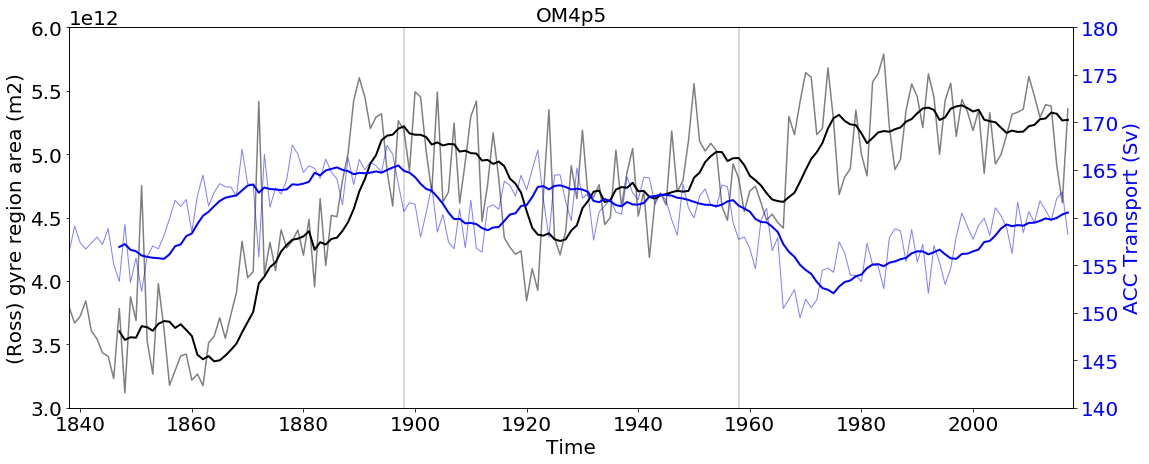

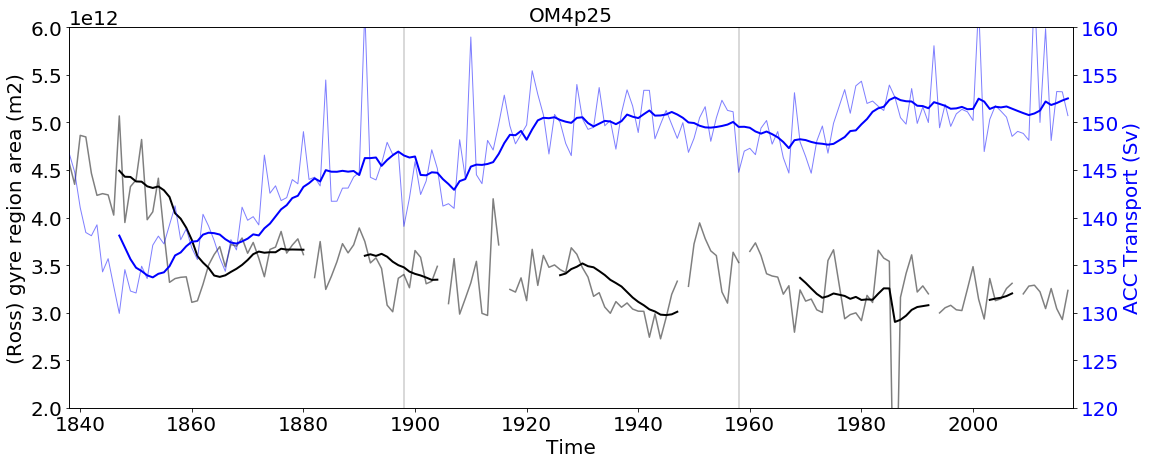

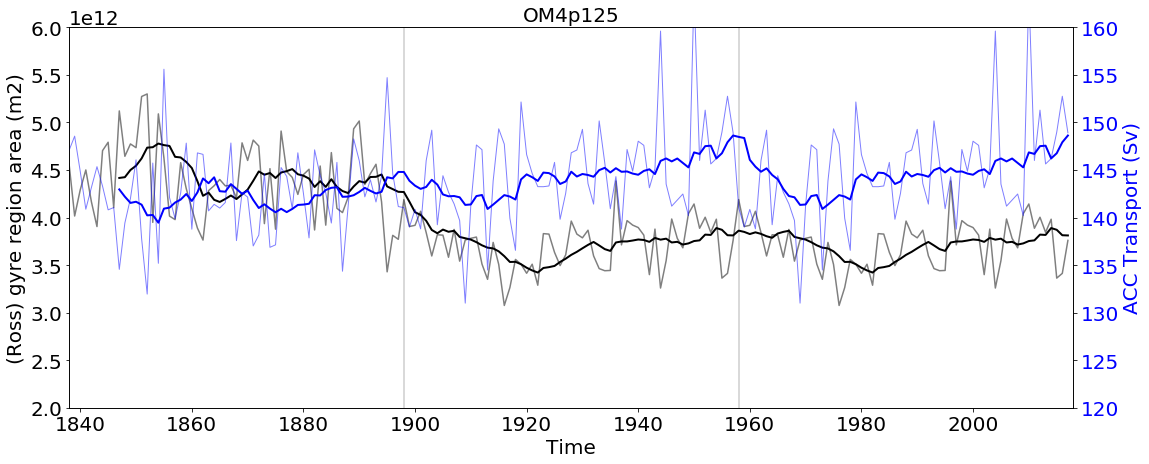

In [178]:
plt.figure(figsize = (18,7))
ax = plt.subplot()

ax.plot(p5_annual_RG_area.time, p5_annual_RG_area, 'k', alpha = 0.5)
ax.plot(p5_annual_RG_area_rolling.time, p5_annual_RG_area_rolling, 'k', linewidth = 2)
ax.set_ylim([3e12,6e12])
ax.set_xlim([np.datetime64('1838'),np.datetime64('2018')])

ax.plot(np.array(['1898','1898'],dtype = np.datetime64), [3e12,6e12], 'k', alpha = 0.2)
ax.plot(np.array(['1958','1958'],dtype = np.datetime64), [3e12,6e12], 'k', alpha = 0.2)
xticks = np.array(['1840','1860','1880','1900','1920','1940','1960','1980','2000'], dtype = np.datetime64)
ax.set_xticks(xticks)
xticks = np.array([1960,1980,2000,1960,1980,2000,1960,1980,2000])
ax.set_xticklabels(xticks)
ax.set_ylabel('(Ross) gyre region area (m2)')
ax.set_xlabel('Time')

ax1 = ax.twinx()  
ax1.plot(p5_annual_ACC.time, p5_annual_ACC, 'b', linewidth = 1, alpha = 0.5)
ax1.plot(p5_annual_ACC_rolling.time, p5_annual_ACC_rolling, 'b', linewidth = 2)
ax1.set_ylim([140,180])
ax1.set_ylabel('ACC Transport (Sv)', color = 'b')
ax1.tick_params(axis='y', labelcolor='b')
ax.set_title('OM4p5', fontsize = 20)
plt.show()
#
plt.figure(figsize = (18,7))
ax = plt.subplot()

ax.plot(p25_annual_RG_area.time, p25_annual_RG_area, 'k', alpha = 0.5)
ax.plot(p25_annual_RG_area_rolling.time, p25_annual_RG_area_rolling, 'k', linewidth = 2)
ax.set_ylim([2e12,6e12])
ax.set_xlim([np.datetime64('1838'),np.datetime64('2018')])

ax.plot(np.array(['1898','1898'],dtype = np.datetime64), [2e12,6e12], 'k', alpha = 0.2)
ax.plot(np.array(['1958','1958'],dtype = np.datetime64), [2e12,6e12], 'k', alpha = 0.2)
xticks = np.array(['1840','1860','1880','1900','1920','1940','1960','1980','2000'], dtype = np.datetime64)
ax.set_xticks(xticks)
xticks = np.array([1960,1980,2000,1960,1980,2000,1960,1980,2000])
ax.set_xticklabels(xticks)
ax.set_ylabel('(Ross) gyre region area (m2)')
ax.set_xlabel('Time')

ax1 = ax.twinx()  
ax1.plot(p25_annual_ACC.time, p25_annual_ACC, 'b', linewidth = 1, alpha = 0.5)
ax1.plot(p25_annual_ACC_rolling.time, p25_annual_ACC_rolling, 'b', linewidth = 2)
ax1.set_ylim([120,160])
ax1.set_ylabel('ACC Transport (Sv)', color = 'b')
ax1.tick_params(axis='y', labelcolor='b')
ax.set_title('OM4p25', fontsize = 20)
plt.show()
#
plt.figure(figsize = (18,7))
ax = plt.subplot()

ax.plot(p125_mle_annual_RG_area.time, p125_mle_annual_RG_area, 'k', alpha = 0.5)
ax.plot(p125_mle_annual_RG_area_rolling.time, p125_mle_annual_RG_area_rolling, 'k', linewidth = 2)
ax.set_ylim([2e12,6e12])
ax.set_xlim([np.datetime64('1838'),np.datetime64('2018')])

ax.plot(np.array(['1898','1898'],dtype = np.datetime64), [2e12,6e12], 'k', alpha = 0.2)
ax.plot(np.array(['1958','1958'],dtype = np.datetime64), [2e12,6e12], 'k', alpha = 0.2)
xticks = np.array(['1840','1860','1880','1900','1920','1940','1960','1980','2000'], dtype = np.datetime64)
ax.set_xticks(xticks)
xticks = np.array([1960,1980,2000,1960,1980,2000,1960,1980,2000])
ax.set_xticklabels(xticks)
ax.set_ylabel('(Ross) gyre region area (m2)')
ax.set_xlabel('Time')

ax1 = ax.twinx()  
ax1.plot(p125_mle_annual_ACC.time, p125_mle_annual_ACC, 'b', linewidth = 1, alpha = 0.5)
ax1.plot(p125_mle_annual_ACC_rolling.time, p125_mle_annual_ACC_rolling, 'b', linewidth = 2)
ax1.set_ylim([120,160])
ax1.set_ylabel('ACC Transport (Sv)', color = 'b')
ax1.tick_params(axis='y', labelcolor='b')
ax.set_title('OM4p125', fontsize = 20)
plt.show()


In [ ]:
WG_mask5 = (geolon.where(geolon>-65).where(geolon<59.7)*0+1).where(geolat<-45).where(geolat>-78)


In [179]:
## Ross/Weddell/Kerguellen Gyre area
p5_annual_WG_mask = p5_annual_gyre_mask.where(p5_annual_gyre_mask.geolon>-65)
p25_annual_WG_mask = p25_annual_gyre_mask.where(p25_annual_gyre_mask.geolon>-65)
p125_annual_WG_mask = p125_annual_gyre_mask.where(p125_annual_gyre_mask.geolon>-65) 
p125_mle_annual_WG_mask = p125_mle_annual_gyre_mask.where(p125_mle_annual_gyre_mask.geolon>-65) 
 
p5_annual_WG_area = (p5_annual_WG_mask*area_cell_5).sum(dim = {'yh', 'xq'}).load()
p25_annual_WG_area = (p25_annual_WG_mask*area_cell_25).sum(dim = {'yh', 'xq'}).load()
p125_annual_WG_area = (p125_annual_WG_mask*area_cell_125).sum(dim = {'yh', 'xq'}).load()
p125_mle_annual_WG_area = (p125_mle_annual_WG_mask*area_cell_125).sum(dim = {'yh', 'xq'}).load()


In [188]:
p5_annual_WG_area = p5_annual_WG_area.where(p5_annual_WG_area>1e12)
p25_annual_WG_area = p25_annual_WG_area.where(p25_annual_WG_area>1e12)
p125_annual_WG_area = p125_annual_WG_area.where(p125_annual_WG_area>1e12)
p125_mle_annual_WG_area = p125_mle_annual_WG_area.where(p125_mle_annual_WG_area>1e12)

In [189]:
p5_annual_WG_area_rolling = p5_annual_WG_area.rolling(time = 10).mean()
p25_annual_WG_area_rolling = p25_annual_WG_area.rolling(time = 10).mean()
p125_annual_WG_area_rolling = p125_annual_WG_area.rolling(time = 10).mean()
p125_mle_annual_WG_area_rolling = p125_mle_annual_WG_area.rolling(time = 10).mean()

In [199]:
p125_mle_annual_WG_area.max()

<xarray.DataArray ()>
array(9.87422117e+12)

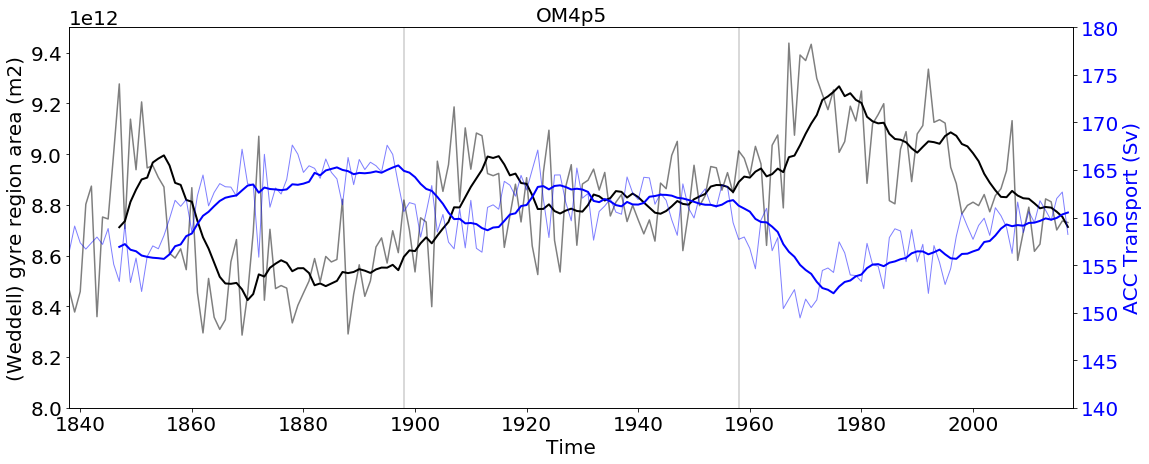

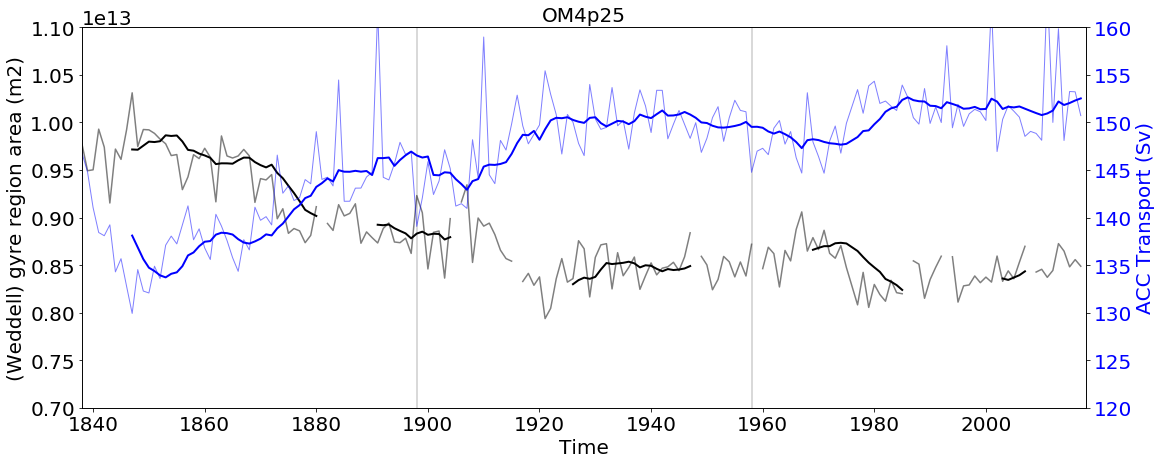

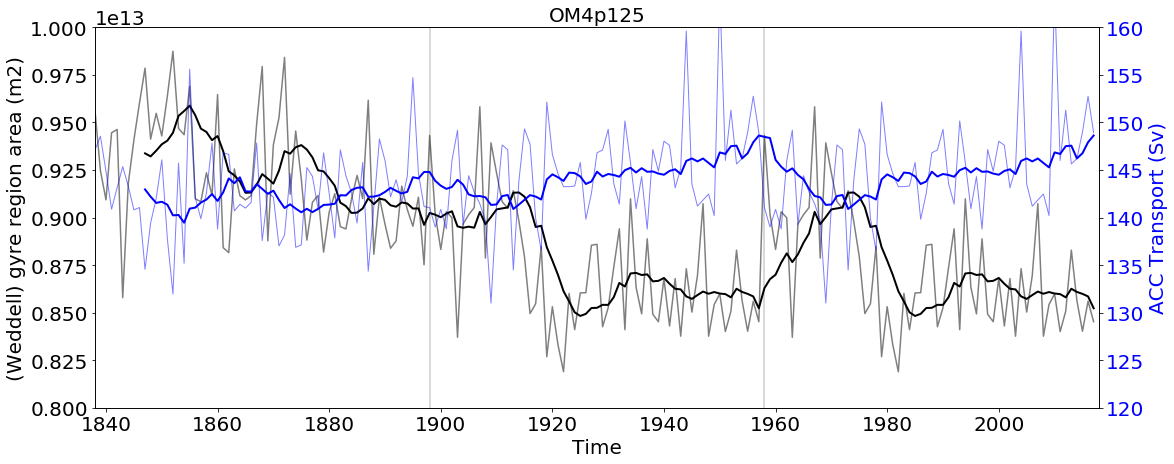

In [200]:
plt.figure(figsize = (18,7))
ax = plt.subplot()

ax.plot(p5_annual_WG_area.time, p5_annual_WG_area, 'k', alpha = 0.5)
ax.plot(p5_annual_WG_area_rolling.time, p5_annual_WG_area_rolling, 'k', linewidth = 2)
ax.set_ylim([8e12,9.5e12])
ax.set_xlim([np.datetime64('1838'),np.datetime64('2018')])

ax.plot(np.array(['1898','1898'],dtype = np.datetime64), [8e12,9.5e12], 'k', alpha = 0.2)
ax.plot(np.array(['1958','1958'],dtype = np.datetime64), [8e12,9.5e12], 'k', alpha = 0.2)
xticks = np.array(['1840','1860','1880','1900','1920','1940','1960','1980','2000'], dtype = np.datetime64)
ax.set_xticks(xticks)
xticks = np.array([1960,1980,2000,1960,1980,2000,1960,1980,2000])
ax.set_xticklabels(xticks)
ax.set_ylabel('(Weddell) gyre region area (m2)')
ax.set_xlabel('Time')

ax1 = ax.twinx()  
ax1.plot(p5_annual_ACC.time, p5_annual_ACC, 'b', linewidth = 1, alpha = 0.5)
ax1.plot(p5_annual_ACC_rolling.time, p5_annual_ACC_rolling, 'b', linewidth = 2)
ax1.set_ylim([140,180])
ax1.set_ylabel('ACC Transport (Sv)', color = 'b')
ax1.tick_params(axis='y', labelcolor='b')
ax.set_title('OM4p5', fontsize = 20)
plt.show()
#
plt.figure(figsize = (18,7))
ax = plt.subplot()

ax.plot(p25_annual_WG_area.time, p25_annual_WG_area, 'k', alpha = 0.5)
ax.plot(p25_annual_WG_area_rolling.time, p25_annual_WG_area_rolling, 'k', linewidth = 2)
ax.set_ylim([7e12,11e12])
ax.set_xlim([np.datetime64('1838'),np.datetime64('2018')])

ax.plot(np.array(['1898','1898'],dtype = np.datetime64), [7e12,11e12], 'k', alpha = 0.2)
ax.plot(np.array(['1958','1958'],dtype = np.datetime64), [7e12,11e12], 'k', alpha = 0.2)
xticks = np.array(['1840','1860','1880','1900','1920','1940','1960','1980','2000'], dtype = np.datetime64)
ax.set_xticks(xticks)
xticks = np.array([1960,1980,2000,1960,1980,2000,1960,1980,2000])
ax.set_xticklabels(xticks)
ax.set_ylabel('(Weddell) gyre region area (m2)')
ax.set_xlabel('Time')

ax1 = ax.twinx()  
ax1.plot(p25_annual_ACC.time, p25_annual_ACC, 'b', linewidth = 1, alpha = 0.5)
ax1.plot(p25_annual_ACC_rolling.time, p25_annual_ACC_rolling, 'b', linewidth = 2)
ax1.set_ylim([120,160])
ax1.set_ylabel('ACC Transport (Sv)', color = 'b')
ax1.tick_params(axis='y', labelcolor='b')
ax.set_title('OM4p25', fontsize = 20)
plt.show()
#
plt.figure(figsize = (18,7))
ax = plt.subplot()

ax.plot(p125_mle_annual_WG_area.time, p125_mle_annual_WG_area, 'k', alpha = 0.5)
ax.plot(p125_mle_annual_WG_area_rolling.time, p125_mle_annual_WG_area_rolling, 'k', linewidth = 2)
ax.set_ylim([8e12,10e12])
ax.set_xlim([np.datetime64('1838'),np.datetime64('2018')])

ax.plot(np.array(['1898','1898'],dtype = np.datetime64), [8e12,10e12], 'k', alpha = 0.2)
ax.plot(np.array(['1958','1958'],dtype = np.datetime64), [8e12,10e12], 'k', alpha = 0.2)
xticks = np.array(['1840','1860','1880','1900','1920','1940','1960','1980','2000'], dtype = np.datetime64)
ax.set_xticks(xticks)
xticks = np.array([1960,1980,2000,1960,1980,2000,1960,1980,2000])
ax.set_xticklabels(xticks)
ax.set_ylabel('(Weddell) gyre region area (m2)')
ax.set_xlabel('Time')

ax1 = ax.twinx()  
ax1.plot(p125_mle_annual_ACC.time, p125_mle_annual_ACC, 'b', linewidth = 1, alpha = 0.5)
ax1.plot(p125_mle_annual_ACC_rolling.time, p125_mle_annual_ACC_rolling, 'b', linewidth = 2)
ax1.set_ylim([120,160])
ax1.set_ylabel('ACC Transport (Sv)', color = 'b')
ax1.tick_params(axis='y', labelcolor='b')
ax.set_title('OM4p125', fontsize = 20)
plt.show()
